# Speech Emotion Recognition with Hybrid Deep Learning Models and Data Augmentation

In this notebook, we'll explore how to improve **Speech Emotion Recognition** using **Hybrid Deep Learning Models** and **Data Augmentation**. We will:

- Import the necessary libraries.
- Extract features from audio files using **Librosa**.
- Visualize and analyze the data.

### Libraries used:

- **Pandas**: For data manipulation.
- **NumPy**: For numerical operations.
- **Librosa**: For analyzing and processing audio files.
- **Seaborn** and **Matplotlib**: For data visualization.
- **OS** and **Sys**: For handling file paths and system operations.

### Importing Libraries:

In [85]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

### Additional Libraries for Data Preprocessing and Evaluation

We will also use the following libraries for preprocessing the data, splitting it into training and testing sets, and evaluating the model's performance:

- **StandardScaler**: For feature scaling.
- **OneHotEncoder**: For encoding categorical variables (if applicable).
- **ConfusionMatrix** and **ClassificationReport**: For evaluating model performance.
- **TrainTestSplit**: For splitting the dataset into training and testing sets.

### Importing Additional Libraries:

In [86]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


### Libraries for Model Building and Audio Playback

To build the deep learning model and play audio files, we will use the following libraries:

- **IPython.display**: To play audio files within the notebook.
- **Keras**: For building and training the deep learning model.
  - Layers like **LSTM**, **GRU**, **Conv1D**, and **Dense** for constructing the neural network.
  - **ModelCheckpoint** to save the best model during training.
  - **SGD** as the optimizer for training the model.
- **Tokenizer and Sequence Preprocessing**: For handling text and padding sequences.

### Importing Libraries for Audio Playback and Model Building:

In [87]:
# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
#from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD


In [88]:
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf
print ("Done")

Done


### Installing System Dependencies

Before we proceed with audio file processing, we need to install the **libsndfile1** library, which is required for handling certain audio file formats. We will also update the system's package list.

Run the following commands to install the necessary dependencies:

In [89]:

!apt-get update
!apt-get install -y libsndfile1

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,677 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,762 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,692 kB]
Get:14 http:/

### Downloading and Moving the Dataset

To work with the RAVDESS Emotional Speech Audio dataset, we'll use **KaggleHub** to download it and then move it to the desired directory for easier access.

### Steps:

1. **Download the Dataset**: Using **KaggleHub**, we'll download the dataset to the default cache directory.
2. **Move the Dataset**: We'll move the dataset to the `/content/sample_data/` directory for easier use.

Here’s the code to download and move the dataset:

In [93]:
import kagglehub
import shutil
import os

# Download the dataset (defaults to ~/.cache/kagglehub/datasets)
dataset_path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

# Define your target path
destination_path = "/content/sample_data/"

# Ensure the destination directory exists
os.makedirs(destination_path, exist_ok=True)

# Move the dataset to the desired location
shutil.move(dataset_path, destination_path)

print("Dataset moved to:", destination_path)


Error: Destination path '/content/sample_data/1' already exists

In [178]:
ravdess = "/content/sample_data/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['anscombe.json', 'README.md', 'savee_dataset', 'cremad_dataset', '1', 'tess_dataset', 'mnist_test.csv', 'california_housing_train.csv', 'mnist_train_small.csv', 'california_housing_test.csv']


In [95]:
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

# **Preprocessing**

### Processing Audio Files for Emotion Classification

In this section, we'll process the RAVDESS dataset to extract emotion labels and file paths for further analysis. The process involves:

1. **Iterating through directories**: We'll navigate through each actor's folder in the dataset.
2. **File validation**: We'll check for valid audio file extensions (e.g., `.wav`, `.mp3`, `.flac`) and skip any files with unsupported extensions.
3. **Splitting filenames**: We'll split filenames to extract emotion labels, assuming the file format follows a specific structure.
4. **Storing results**: We'll store the emotion labels and file paths for further use.

In [96]:
import os

# Directory where your files are stored
ravdess = '/content/sample_data/1'  # Adjust this to your directory path
ravdess_directory_list = os.listdir(ravdess)

file_emotion = []
file_path = []

# List of valid file extensions to process (adjust as necessary)
valid_extensions = ['.wav', '.mp3', '.flac']

for i in ravdess_directory_list:
    actor_dir = os.path.join(ravdess, i)

    # Only process if it's a directory (skip non-directory entries like 'audio_speech_actors_01-24')
    if os.path.isdir(actor_dir):
        actor_files = os.listdir(actor_dir)
        for f in actor_files:
            print(f"Processing file: {f}")  # Print filename for inspection

            # Check if file has a valid extension
            if not any(f.endswith(ext) for ext in valid_extensions):
                print(f"Skipping file with unsupported extension: {f}")
                continue  # Skip unsupported file extensions

            # Split the filename based on '.' and '-'
            part = f.split('.')[0].split('-')

            # Print the split result for debugging
            print(f"Parts after split: {part}")

            if len(part) >= 3:  # Ensure that we have at least 3 parts
                try:
                    # Append the emotion (the 3rd part) and full file path
                    file_emotion.append(int(part[2]))  # The 3rd part is the emotion
                    file_path.append(os.path.join(actor_dir, f))
                except ValueError:
                    print(f"Skipping file due to invalid emotion format: {f}")
            else:
                print(f"Skipping file due to unexpected format: {f}")

# Print the first 10 entries as a check
print("First 10 file emotions:", file_emotion[:10])
print("First 10 file paths:", file_path[:10])


Processing file: 03-01-04-01-02-01-24.wav
Parts after split: ['03', '01', '04', '01', '02', '01', '24']
Processing file: 03-01-08-01-02-01-24.wav
Parts after split: ['03', '01', '08', '01', '02', '01', '24']
Processing file: 03-01-04-01-01-01-24.wav
Parts after split: ['03', '01', '04', '01', '01', '01', '24']
Processing file: 03-01-03-02-01-01-24.wav
Parts after split: ['03', '01', '03', '02', '01', '01', '24']
Processing file: 03-01-08-02-01-01-24.wav
Parts after split: ['03', '01', '08', '02', '01', '01', '24']
Processing file: 03-01-02-02-02-02-24.wav
Parts after split: ['03', '01', '02', '02', '02', '02', '24']
Processing file: 03-01-04-02-02-02-24.wav
Parts after split: ['03', '01', '04', '02', '02', '02', '24']
Processing file: 03-01-05-02-02-02-24.wav
Parts after split: ['03', '01', '05', '02', '02', '02', '24']
Processing file: 03-01-04-01-02-02-24.wav
Parts after split: ['03', '01', '04', '01', '02', '02', '24']
Processing file: 03-01-02-01-02-01-24.wav
Parts after split: ['0

In [97]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())

   Emotions                                               Path
0       sad  /content/sample_data/1/Actor_24/03-01-04-01-02...
1  surprise  /content/sample_data/1/Actor_24/03-01-08-01-02...
2       sad  /content/sample_data/1/Actor_24/03-01-04-01-01...
3     happy  /content/sample_data/1/Actor_24/03-01-03-02-01...
4  surprise  /content/sample_data/1/Actor_24/03-01-08-02-01...
______________________________________________
      Emotions                                               Path
1435      fear  /content/sample_data/1/Actor_12/03-01-06-02-01...
1436  surprise  /content/sample_data/1/Actor_12/03-01-08-02-02...
1437   neutral  /content/sample_data/1/Actor_12/03-01-02-02-01...
1438     angry  /content/sample_data/1/Actor_12/03-01-05-01-02...
1439  surprise  /content/sample_data/1/Actor_12/03-01-08-02-01...
_______________________________________________
Emotions
neutral     288
surprise    192
sad         192
happy       192
angry       192
fear        192
disgust     192
Name: coun

<ipython-input-97-48e4565091c5>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',


# **Crema DataFrame**

### Upgrading Librosa

To ensure we are using the latest version of **Librosa** for audio processing, we will upgrade it using the following command. This will help avoid any issues related to older versions and ensure compatibility with the features we need.


In [98]:
!pip install --upgrade librosa


### Downloading and Moving the CREMA-D Dataset

We will download the **CREMA-D** dataset using **KaggleHub** and move it to the appropriate directory for easier access. The dataset will be downloaded to the default cache directory, and we will ensure it is placed in a unique subfolder within `/content/sample_data/`.

### Steps:

1. **Download the Dataset**: Using **KaggleHub**, we will download the **CREMA-D** dataset.
2. **Check for Existing Folder**: If the folder already exists, we will create a new unique folder name.
3. **Move the Dataset**: After ensuring the destination folder exists, we will move the dataset to the `/content/sample_data/cremad_dataset/` directory.

In [99]:
import kagglehub
import shutil
import os

# Download the dataset (defaults to ~/.cache/kagglehub/datasets)
dataset_path = kagglehub.dataset_download("ejlok1/cremad")

# Define the base target path where you want the dataset to be moved
destination_base_path = "/content/sample_data/cremad_dataset/"

# Check if the folder exists, and create a unique folder name if necessary
destination_path = destination_base_path
counter = 1
while os.path.exists(destination_path):
    destination_path = f"{destination_base_path}_{counter}"
    counter += 1

# Ensure the destination directory exists
os.makedirs(destination_path, exist_ok=True)

# Move the dataset to the desired location
shutil.move(dataset_path, destination_path)

print("Dataset moved to:", destination_path)


100%|██████████| 451M/451M [00:11<00:00, 42.9MB/s]

Extracting files...


Dataset moved to: /content/sample_data/cremad_dataset/_1


### Processing the CREMA-D Dataset for Emotion Classification

In this section, we will process the **CREMA-D** dataset to extract emotion labels and file paths. The process involves:

1. **Listing Files**: We first list all audio files in the "AudioWAV" folder from the CREMA-D dataset.
2. **Filtering and Extracting Emotion Labels**: We filter the files to include only `.wav` files and extract emotion labels based on the filename convention (e.g., "SAD" for sad, "ANG" for angry).
3. **Storing the Data**: We store the emotion labels and file paths in separate lists, which are later combined into a DataFrame for easier manipulation and analysis.

In [100]:
import os
import pandas as pd

# Path where the dataset has been moved
Crema = "/content/sample_data/cremad_dataset/"

# List the directories inside the "AudioWAV" folder
crema_directory_list = os.listdir(os.path.join(Crema, "1", "AudioWAV"))

file_emotion = []
file_path = []

for file in crema_directory_list:
    # Ensure the file is an audio file (this checks for .wav files)
    if file.endswith(".wav"):
        # Storing file paths
        file_path.append(os.path.join(Crema, "1", "AudioWAV", file))

        # Splitting the filename to get the emotion
        part = file.split('_')

        # Store emotions based on file name convention
        try:
            if part[2] == 'SAD':
                file_emotion.append('sad')
            elif part[2] == 'ANG':
                file_emotion.append('angry')
            elif part[2] == 'DIS':
                file_emotion.append('disgust')
            elif part[2] == 'FEA':
                file_emotion.append('fear')
            elif part[2] == 'HAP':
                file_emotion.append('happy')
            elif part[2] == 'NEU':
                file_emotion.append('neutral')
            else:
                file_emotion.append('Unknown')
        except IndexError:
            # Handle case where the filename doesn't have enough parts
            file_emotion.append('Invalid')
            print(f"Filename '{file}' is not in the expected format.")

# Create dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Create dataframe for path of files
path_df = pd.DataFrame(file_path, columns=['Path'])

# Combine both dataframes into one
Crema_df = pd.concat([emotion_df, path_df], axis=1)

# Display first few rows to check
print(Crema_df.head())

# Print the distribution of emotions in the dataset
print(Crema_df.Emotions.value_counts())


  Emotions                                               Path
0      sad  /content/sample_data/cremad_dataset/1/AudioWAV...
1      sad  /content/sample_data/cremad_dataset/1/AudioWAV...
2     fear  /content/sample_data/cremad_dataset/1/AudioWAV...
3      sad  /content/sample_data/cremad_dataset/1/AudioWAV...
4    happy  /content/sample_data/cremad_dataset/1/AudioWAV...
Emotions
sad        1271
fear       1271
happy      1271
angry      1271
disgust    1271
neutral    1087
Name: count, dtype: int64


# **TESS dataset**

### Downloading and Moving the TESS Dataset

We will download the **Toronto Emotional Speech Set (TESS)** dataset using **KaggleHub** and move it to the appropriate directory for easier access. The dataset will be downloaded to the default cache directory, and we will ensure it is placed in a unique subfolder within `/content/sample_data/`.

### Steps:

1. **Download the Dataset**: Using **KaggleHub**, we will download the **TESS** dataset.
2. **Check for Existing Folder**: If the folder already exists, we will create a new unique folder name.
3. **Move the Dataset**: After ensuring the destination folder exists, we will move the dataset to the `/content/sample_data/tess_dataset/` directory.


In [101]:
import kagglehub
import shutil
import os

# Download the dataset (defaults to ~/.cache/kagglehub/datasets)
dataset_path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

# Define the base target path where you want the dataset to be moved
destination_base_path = "/content/sample_data/tess_dataset/"

# Check if the folder exists, and create a unique folder name if necessary
destination_path = destination_base_path
counter = 1
while os.path.exists(destination_path):
    destination_path = f"{destination_base_path}_{counter}"
    counter += 1

# Ensure the destination directory exists
os.makedirs(destination_path, exist_ok=True)

# Move the dataset to the desired location
shutil.move(dataset_path, destination_path)

print("Dataset moved to:", destination_path)


100%|██████████| 428M/428M [00:06<00:00, 67.9MB/s]

Extracting files...


Dataset moved to: /content/sample_data/tess_dataset/_1


### Inspecting the TESS Dataset Structure

In this step, we will inspect the structure of the **Toronto Emotional Speech Set (TESS)** dataset by listing the directories and files within it. This will help us understand how the dataset is organized before we proceed with further processing.

The following steps will be taken:

1. **List the Directories**: We will first list the directories present in the dataset.
2. **Print the Files**: For each directory, we will print the names of the files it contains to better understand the organization.

In [102]:
import os

# Define the directory path for TESS dataset
Tess = "/content/sample_data/tess_dataset/"  # Replace with the actual path

# List the directories in the TESS dataset
tess_directory_list = os.listdir(Tess)

# Print directory and file names to inspect the structure
for dir in tess_directory_list:
    dir_path = os.path.join(Tess, dir)
    if os.path.isdir(dir_path):  # Ensure it's a directory
        print(f"Directory: {dir}")
        files = os.listdir(dir_path)
        for file in files:
            print(f"  File: {file}")


Directory: 1
  File: TESS Toronto emotional speech set data
  File: tess toronto emotional speech set data
Directory: _1
  File: 1


In [104]:
import os

# Define the directory path for TESS dataset
Tess = "/content/sample_data/tess_dataset/"  # Replace with the actual path

# Recursively list directories and files
def list_files_recursively(base_dir):
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            print(f"File: {file}, Path: {os.path.join(root, file)}")

# List files recursively in the TESS dataset
list_files_recursively(Tess)


File: OAF_phone_disgust.wav, Path: /content/sample_data/tess_dataset/1/TESS Toronto emotional speech set data/OAF_disgust/OAF_phone_disgust.wav
File: OAF_vote_disgust.wav, Path: /content/sample_data/tess_dataset/1/TESS Toronto emotional speech set data/OAF_disgust/OAF_vote_disgust.wav
File: OAF_back_disgust.wav, Path: /content/sample_data/tess_dataset/1/TESS Toronto emotional speech set data/OAF_disgust/OAF_back_disgust.wav
File: OAF_such_disgust.wav, Path: /content/sample_data/tess_dataset/1/TESS Toronto emotional speech set data/OAF_disgust/OAF_such_disgust.wav
File: OAF_perch_disgust.wav, Path: /content/sample_data/tess_dataset/1/TESS Toronto emotional speech set data/OAF_disgust/OAF_perch_disgust.wav
File: OAF_far_disgust.wav, Path: /content/sample_data/tess_dataset/1/TESS Toronto emotional speech set data/OAF_disgust/OAF_far_disgust.wav
File: OAF_tape_disgust.wav, Path: /content/sample_data/tess_dataset/1/TESS Toronto emotional speech set data/OAF_disgust/OAF_tape_disgust.wav
File

In [106]:
import os
import pandas as pd

# Define the directory path for TESS dataset
Tess = "/content/sample_data/tess_dataset/1/TESS Toronto emotional speech set data"  # Replace with the actual path

# List the directories in the TESS dataset
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

# Process each directory and file within the TESS dataset
for dir in tess_directory_list:
    dir_path = os.path.join(Tess, dir)  # Join to ensure the proper path
    if os.path.isdir(dir_path):  # Ensure it's a directory
        directories = os.listdir(dir_path)

        for file in directories:
            file_path_full = os.path.join(dir_path, file)  # Full path of the file

            # Debug: Check if it's a .wav file
            if os.path.isdir(file_path_full):
                continue  # Skip directories

            # Check if the file is a .wav file
            if not file.lower().endswith('.wav'):
                continue  # Skip non-audio files

            # Debug: Output the filenames being processed
            print(f"Processing file: {file}")

            # Split the filename to extract the emotion
            part = file.split('.')[0].split('_')

            # Debug: Print the parts of the filename
            print(f"Filename parts: {part}")

            if len(part) >= 3:  # Ensure the filename has the expected number of parts
                emotion = part[2]  # Emotion is at index 2 of the split file name

                # Debug: Check the extracted emotion
                print(f"Extracted emotion: {emotion}")

                # Check and map the emotion
                if emotion == 'ps':  # 'ps' is mapped to 'surprise'
                    file_emotion.append('surprise')
                elif emotion in ['h', 'a', 's', 'f', 'd']:  # Map other emotions
                    emotion_mapping = {'h': 'happiness', 'a': 'anger', 's': 'sadness', 'f': 'fear', 'd': 'disgust'}
                    file_emotion.append(emotion_mapping.get(emotion, 'unknown'))  # Use 'unknown' for unexpected emotion codes
                else:
                    file_emotion.append(emotion)

                # Construct the full file path
                file_path.append(file_path_full)
            else:
                print(f"Skipping file with unexpected format: {file}")

# Create a dataframe for emotions
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Create a dataframe for file paths
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenate both dataframes
Tess_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows
print(Tess_df.head())

# Print the count of each emotion in the dataset
print(Tess_df.Emotions.value_counts())


Processing file: OAF_phone_disgust.wav
Filename parts: ['OAF', 'phone', 'disgust']
Extracted emotion: disgust
Processing file: OAF_vote_disgust.wav
Filename parts: ['OAF', 'vote', 'disgust']
Extracted emotion: disgust
Processing file: OAF_back_disgust.wav
Filename parts: ['OAF', 'back', 'disgust']
Extracted emotion: disgust
Processing file: OAF_such_disgust.wav
Filename parts: ['OAF', 'such', 'disgust']
Extracted emotion: disgust
Processing file: OAF_perch_disgust.wav
Filename parts: ['OAF', 'perch', 'disgust']
Extracted emotion: disgust
Processing file: OAF_far_disgust.wav
Filename parts: ['OAF', 'far', 'disgust']
Extracted emotion: disgust
Processing file: OAF_tape_disgust.wav
Filename parts: ['OAF', 'tape', 'disgust']
Extracted emotion: disgust
Processing file: OAF_learn_disgust.wav
Filename parts: ['OAF', 'learn', 'disgust']
Extracted emotion: disgust
Processing file: OAF_match_disgust.wav
Filename parts: ['OAF', 'match', 'disgust']
Extracted emotion: disgust
Processing file: OAF_m

# **SAVEE Dataset**

In [19]:
import kagglehub
import shutil
import os

# Download the dataset (defaults to ~/.cache/kagglehub/datasets)
dataset_path = kagglehub.dataset_download("barelydedicated/savee-database")

# Define the base target path where you want the dataset to be moved
destination_base_path = "/content/sample_data/savee_dataset/"  # Update this path as necessary

# Check if the folder exists, and create a unique folder name if necessary
destination_path = destination_base_path
counter = 1
while os.path.exists(destination_path):
    destination_path = f"{destination_base_path}_{counter}"
    counter += 1

# Ensure the destination directory exists
os.makedirs(destination_path, exist_ok=True)

# Move the dataset to the desired location
shutil.move(dataset_path, destination_path)

print("Dataset moved to:", destination_path)


100%|██████████| 215M/215M [00:01<00:00, 123MB/s]

Extracting files...


Dataset moved to: /content/sample_data/savee_dataset/


In [109]:
import os
import pandas as pd

# Define the directory path for the SAVE dataset
Savee = "/content/sample_data/savee_dataset/1"  # Path to the main folder containing 'AudioData' and 'audiodata'

# List the directories in the SAVE dataset
savee_directory_list = os.listdir(Savee)

# Debug: List the subdirectories
print(f"Subdirectories found: {savee_directory_list}")

# Initialize lists for emotions and paths
file_emotion = []
file_path = []

# Recursive function to process directories and files
def process_directory(directory_path):
    # List the files and directories in the current directory
    for item in os.listdir(directory_path):
        item_path = os.path.join(directory_path, item)

        if os.path.isdir(item_path):  # If it's a directory, process it further
            print(f"Entering subdirectory: {item_path}")
            process_directory(item_path)
        elif item.lower().endswith('.wav'):  # If it's a .wav file
            # Extract emotion from the first character(s) of the filename
            emotion_code = item[0:2] if item[1:2] == 'a' else item[0]  # First 2 chars for 'sa' (sad) otherwise 1 char

            # Debug: Output the filenames being processed
            print(f"Processing file: {item}")

            # Map emotion codes to human-readable emotions
            if emotion_code == 'a':
                file_emotion.append('angry')
            elif emotion_code == 'd':
                file_emotion.append('disgust')
            elif emotion_code == 'f':
                file_emotion.append('fear')
            elif emotion_code == 'h':
                file_emotion.append('happy')
            elif emotion_code == 'n':
                file_emotion.append('neutral')
            elif emotion_code == 'sa':  # For 'sad'
                file_emotion.append('sad')
            else:
                file_emotion.append('surprise')

            # Append the full file path
            file_path.append(item_path)

# Start processing the main directory
process_directory(Savee)

# Create a dataframe for emotions
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Create a dataframe for file paths
path_df = pd.DataFrame(file_path, columns=['Path'])

# Concatenate both dataframes into one
Savee_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows of the dataframe
print(Savee_df.head())

# Print the count of each emotion in the dataset
print(Savee_df.Emotions.value_counts())


Subdirectories found: ['AudioData', 'audiodata']
Entering subdirectory: /content/sample_data/savee_dataset/1/AudioData
Entering subdirectory: /content/sample_data/savee_dataset/1/AudioData/DC
Processing file: su05.wav
Processing file: n19.wav
Processing file: a06.wav
Processing file: n30.wav
Processing file: n25.wav
Processing file: f06.wav
Processing file: sa15.wav
Processing file: d05.wav
Processing file: sa10.wav
Processing file: sa09.wav
Processing file: a05.wav
Processing file: a15.wav
Processing file: su15.wav
Processing file: n24.wav
Processing file: h12.wav
Processing file: n13.wav
Processing file: n29.wav
Processing file: n22.wav
Processing file: su03.wav
Processing file: su01.wav
Processing file: su08.wav
Processing file: h09.wav
Processing file: n01.wav
Processing file: f11.wav
Processing file: sa12.wav
Processing file: sa05.wav
Processing file: a09.wav
Processing file: n26.wav
Processing file: n12.wav
Processing file: d15.wav
Processing file: n03.wav
Processing file: f04.wa

In [133]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,sad,/content/sample_data/1/Actor_24/03-01-04-01-02...
1,surprise,/content/sample_data/1/Actor_24/03-01-08-01-02...
2,sad,/content/sample_data/1/Actor_24/03-01-04-01-01...
3,happy,/content/sample_data/1/Actor_24/03-01-03-02-01...
4,surprise,/content/sample_data/1/Actor_24/03-01-08-02-01...


In [134]:
print(data_path.Emotions.value_counts())

Emotions
neutral     2015
happy       1983
sad         1983
fear        1983
angry       1983
disgust     1983
surprise     712
Name: count, dtype: int64


<ipython-input-112-514f7cbb13f7>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_path, x='Emotions', palette='Set2')  # You can choose different palettes like 'Set1', 'Paired', 'husl', etc.


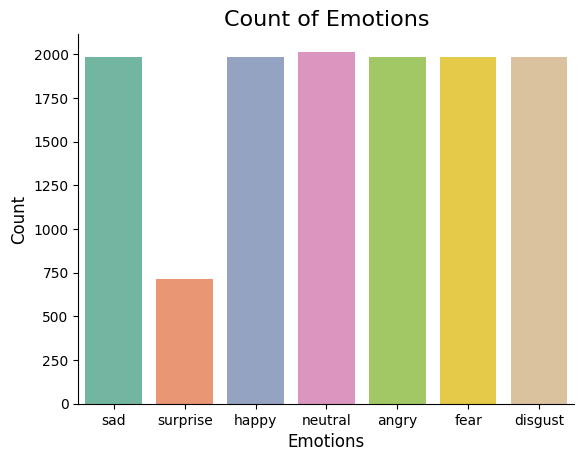

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the title and labels
plt.title('Count of Emotions', size=16)

# Use a colorful palette for the countplot
sns.countplot(data=data_path, x='Emotions', palette='Set2')  # You can choose different palettes like 'Set1', 'Paired', 'husl', etc.

# Set the labels for the axes
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)

# Remove the top and right spines for a cleaner look
sns.despine(top=True, right=True, left=False, bottom=False)

# Display the plot
plt.show()


In [113]:
data,sr = librosa.load(file_path[0])
sr

22050

In [114]:
ipd.Audio(data,rate=sr)

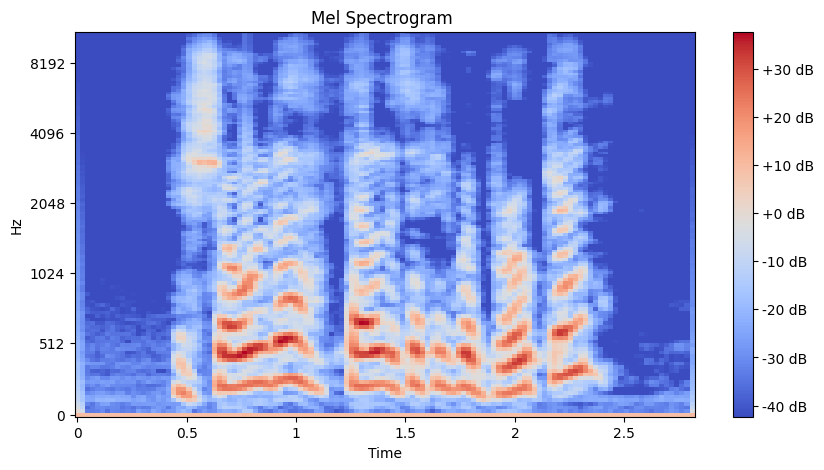

In [115]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

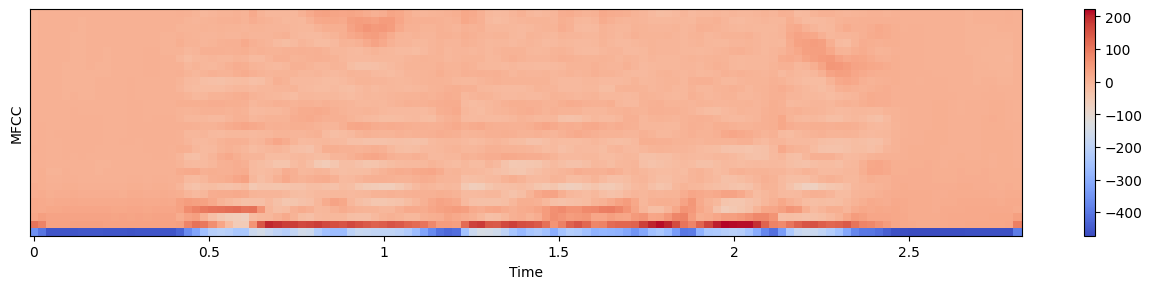

In [116]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

# **Data augmentation**

In [117]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

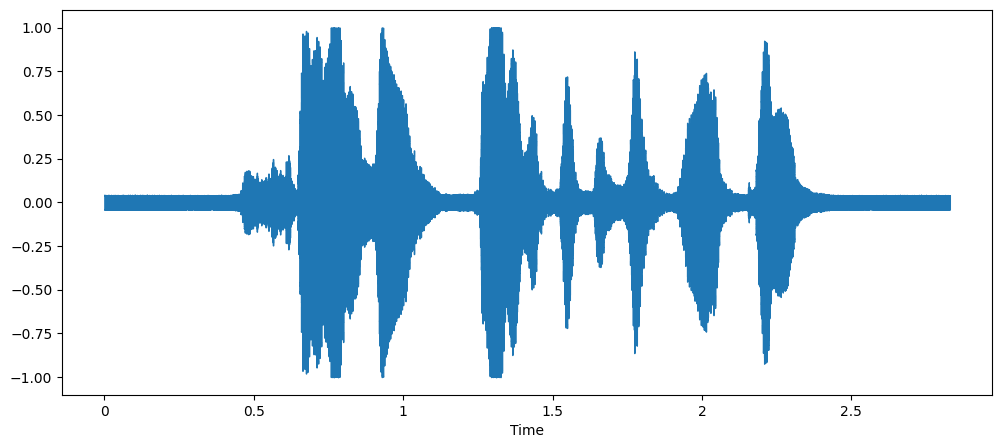

In [118]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

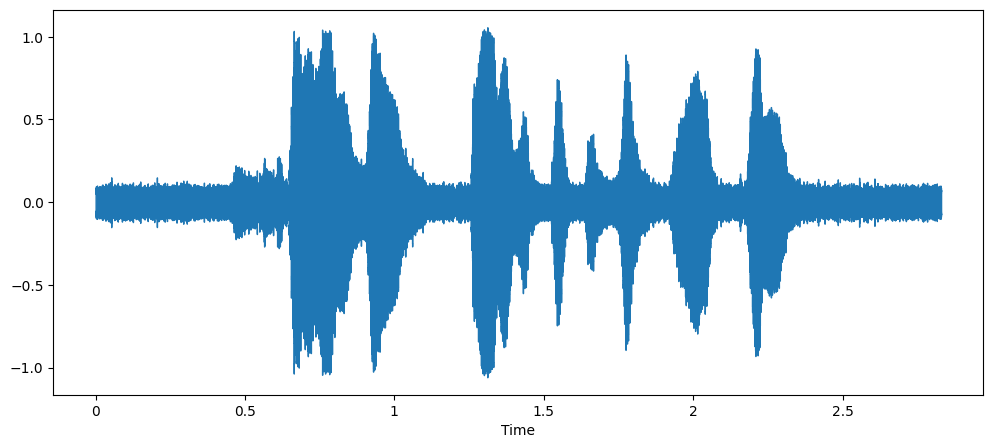

In [119]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

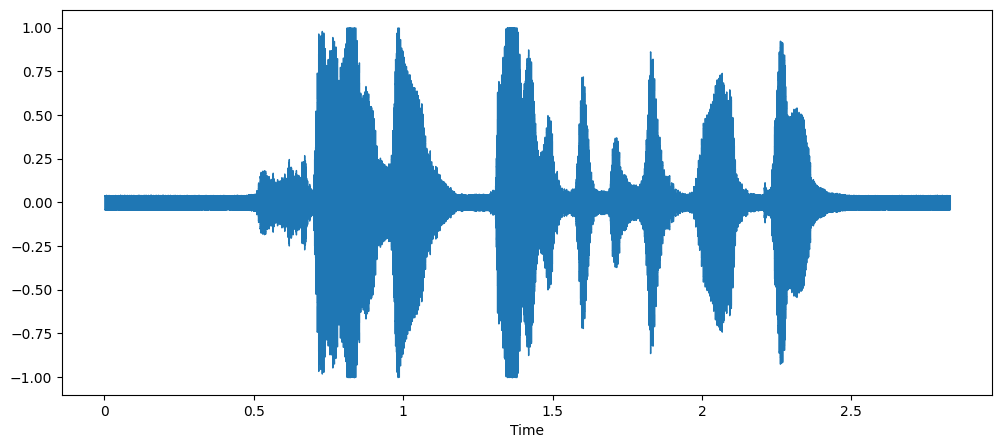

In [120]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

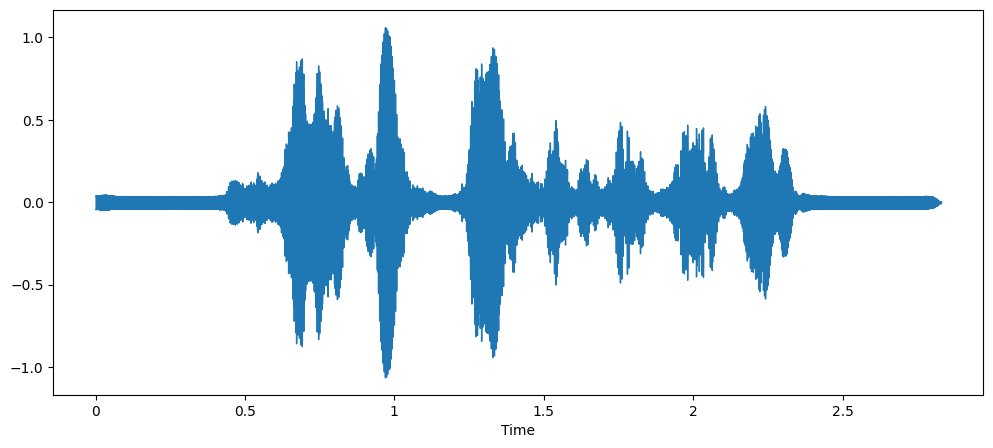

In [121]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

# Assuming 'data' is your audio data and 'sr' is the sampling rate
# Define pitch function
def pitch(data, sampling_rate, pitch_factor=0.7):
    # Pitch shifting
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# Apply pitch shifting to the audio data
x = pitch(data, sr)

# Plot the waveform of the pitch-shifted audio
plt.figure(figsize=(12, 5))
librosa.display.waveshow(x, sr=sr)

# Play the pitch-shifted audio
ipd.Audio(x, rate=sr)


# **Feature extraction**

In [122]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio

In [124]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  2


In [125]:
import librosa
import numpy as np

def rmse(data, frame_length=2048, hop_length=512):
    # Compute the RMS (Root Mean Square) of the audio data
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)  # Squeeze to remove extra dimensions


In [38]:
import os
file_path = '/content/sample_data/cremad_dataset/1/AudioWAV/1017_ITH_SAD_XX.wav'
print(os.path.exists(file_path))  # Should print True if the file exists


True


In [126]:
import timeit
from tqdm import tqdm
import librosa

# Define feature extraction function (example, adapt as needed)
def get_features(path):
    # Load the audio file
    data, sr = librosa.load(path)

    # Extract features (e.g., RMSE, MFCC, etc.)
    rmse_features = rmse(data)
    # Add more feature extraction functions here

    return rmse_features

# Start timer
start = timeit.default_timer()

X, Y = [], []

# Loop through the data and extract features
for path, emotion, index in tqdm(zip(data_path.Path, data_path.Emotions, range(data_path.Path.shape[0]))):
    features = get_features(path)  # Extract features for the audio file
    if index % 500 == 0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)

print('Done')

# Stop timer
stop = timeit.default_timer()

print('Time: ', stop - start)


42it [00:00, 208.29it/s]

0 audio has been processed


522it [00:03, 110.87it/s]

500 audio has been processed


1017it [00:07, 113.80it/s]

1000 audio has been processed


1571it [00:12, 300.62it/s]

1500 audio has been processed


2048it [00:13, 386.54it/s]

2000 audio has been processed


2575it [00:14, 397.95it/s]

2500 audio has been processed


3061it [00:16, 384.27it/s]

3000 audio has been processed


3548it [00:17, 394.80it/s]

3500 audio has been processed


4071it [00:18, 384.91it/s]

4000 audio has been processed


4555it [00:19, 396.25it/s]

4500 audio has been processed


5040it [00:21, 394.72it/s]

5000 audio has been processed


5528it [00:22, 261.69it/s]

5500 audio has been processed


6071it [00:24, 340.67it/s]

6000 audio has been processed


6548it [00:25, 389.94it/s]

6500 audio has been processed


7072it [00:27, 403.59it/s]

7000 audio has been processed


7554it [00:28, 379.48it/s]

7500 audio has been processed


8042it [00:29, 389.28it/s]

8000 audio has been processed


8568it [00:31, 396.27it/s]

8500 audio has been processed


9044it [00:32, 258.39it/s]

9000 audio has been processed


9537it [00:34, 242.97it/s]

9500 audio has been processed


10066it [00:37, 263.86it/s]

10000 audio has been processed


10510it [00:38, 279.59it/s]

10500 audio has been processed


11026it [00:40, 233.36it/s]

11000 audio has been processed


11516it [00:42, 231.31it/s]

11500 audio has been processed


12035it [00:45, 162.05it/s]

12000 audio has been processed


12519it [00:49, 134.09it/s]

12500 audio has been processed


12642it [00:49, 253.39it/s]

Done
Time:  49.89443604200278


In [127]:
len(X), len(Y), data_path.Path.shape

(1457551, 1457551, (12642,))

# Steps to Combine All Datasets and Generate the Final CSV:


In [142]:
import os
import librosa
import pandas as pd
import numpy as np
from glob import glob

# Function to extract features (e.g., MFCCs) from audio files
def extract_features(audio_path):
    try:
        signal, sr = librosa.load(audio_path, sr=22050)
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)  # Extract 13 MFCC features
        return np.mean(mfcc.T, axis=0)  # Return the mean of MFCCs for each audio file
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None  # Return None if there's an issue with the file

# Initialize lists to store the features, emotions, and file paths
all_features = []
all_emotions = []
all_file_paths = []

# Process RAVDESS dataset
ravdess = '/content/sample_data/1'  # Adjust this to your directory path
for actor_dir in os.listdir(ravdess):
    actor_path = os.path.join(ravdess, actor_dir)
    if os.path.isdir(actor_path):
        for file in os.listdir(actor_path):
            if file.endswith(('.wav', '.mp3', '.flac')):  # Validate file extension
                emotion = int(file.split('.')[0].split('-')[2])  # Extract emotion from filename
                file_path = os.path.join(actor_path, file)
                features = extract_features(file_path)
                if features is not None:
                    all_features.append(features)
                    all_emotions.append(emotion)
                    all_file_paths.append(file_path)

# Process CREMA-D dataset
crema = "/content/sample_data/cremad_dataset/"
for file in os.listdir(os.path.join(crema, "1", "AudioWAV")):
    if file.endswith(".wav"):
        file_path = os.path.join(crema, "1", "AudioWAV", file)
        emotion = file.split('_')[2]  # Extract emotion from filename
        features = extract_features(file_path)
        if features is not None:
            all_features.append(features)
            all_emotions.append(emotion)
            all_file_paths.append(file_path)

# Process TESS dataset
tess = "/content/sample_data/tess_dataset/"
for root, dirs, files in os.walk(tess):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            emotion = file.split('_')[2]  # Extract emotion from filename
            features = extract_features(file_path)
            if features is not None:
                all_features.append(features)
                all_emotions.append(emotion)
                all_file_paths.append(file_path)

# Process SAVE (SAVEE) dataset
savee = "/content/sample_data/savee_dataset/1"
for root, dirs, files in os.walk(savee):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            emotion_code = file[0:2] if file[1:2] == 'a' else file[0]
            emotion_map = {
                'a': 'angry', 'd': 'disgust', 'f': 'fear', 'h': 'happy', 'n': 'neutral', 'sa': 'sad', 'su': 'surprise'
            }
            emotion = emotion_map.get(emotion_code, 'Unknown')
            features = extract_features(file_path)
            if features is not None:
                all_features.append(features)
                all_emotions.append(emotion)
                all_file_paths.append(file_path)

# Create a DataFrame with the features and emotion labels
features_df = pd.DataFrame(all_features)
emotion_df = pd.DataFrame(all_emotions, columns=['Emotions'])
file_path_df = pd.DataFrame(all_file_paths, columns=['File Path'])

# Combine the DataFrames into one
final_df = pd.concat([features_df, emotion_df, file_path_df], axis=1)

# Save the final dataset to CSV
final_df.to_csv('combined_emotions.csv', index=False)

print("CSV file generated successfully!")


CSV file generated successfully!


In [141]:
import os
import pandas as pd
import librosa
import numpy as np

# Path where the dataset has been moved
Crema = "/content/sample_data/cremad_dataset/"

# List the directories inside the "AudioWAV" folder
crema_directory_list = os.listdir(os.path.join(Crema, "1", "AudioWAV"))

file_emotion = []
file_features = []

for file in crema_directory_list:
    if file.endswith(".wav"):
        file_path = os.path.join(Crema, "1", "AudioWAV", file)

        # Extract features using librosa
        try:
            y, sr = librosa.load(file_path, sr=None)  # Load the audio file
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Extract 13 MFCCs
            mfccs_mean = np.mean(mfccs, axis=1)  # Take mean of MFCC features

            file_features.append(mfccs_mean.tolist())  # Store as list

            # Extract emotion from filename
            part = file.split('_')
            emotion_code = part[2] if len(part) > 2 else 'Unknown'

            emotion_map = {
                'SAD': 'sad', 'ANG': 'angry', 'DIS': 'disgust',
                'FEA': 'fear', 'HAP': 'happy', 'NEU': 'neutral'
            }
            file_emotion.append(emotion_map.get(emotion_code, 'Unknown'))

        except Exception as e:
            print(f"Error processing {file}: {e}")
            file_features.append([0] * 13)  # Placeholder in case of error
            file_emotion.append('Invalid')

# Convert to DataFrame
feature_columns = [str(i) for i in range(len(file_features[0]))]  # Create column names for features
feature_df = pd.DataFrame(file_features, columns=feature_columns)
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Combine both into final DataFrame
Crema_df = pd.concat([feature_df, emotion_df], axis=1)

# Display first few rows
print(Crema_df.head())
print(Crema_df.Emotions.value_counts())


            0           1          2          3          4         5  \
0 -373.744354  118.051903  33.583878  24.371408  13.851503 -2.180388   
1 -384.493347  117.647125  35.543217  24.248886   9.180931 -3.383929   
2 -301.774750   97.448662  21.046906  19.658953   2.073495 -0.697722   
3 -392.114960   98.456894  50.439285  23.524731  10.247427  3.560805   
4 -358.574615   91.267128  19.408720  11.281754   6.626977  9.446248   

          6         7         8         9        10        11        12  \
0 -4.335654 -3.149419  0.918932  2.612043  2.916094  1.485493 -7.608397   
1 -3.132994  0.441898  5.023551 -1.446066 -1.221411  2.124968 -3.190128   
2 -5.738731 -9.816730 -2.465783  0.491190  2.311452  0.290739 -4.249573   
3 -5.919158 -4.357929 -1.454343 -0.435363 -1.395290 -0.063797 -0.246568   
4 -4.781610 -7.213457  1.403284 -2.278187 -4.676106 -9.360577  0.780957   

  Emotions  
0      sad  
1      sad  
2     fear  
3      sad  
4    happy  
Emotions
sad        1271
fear       12

In [146]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('combined_emotions.csv')

# Drop 'File Path' column and encode emotions
df = df.drop(columns=['File Path'])
label_encoder = LabelEncoder()
df['Emotions'] = label_encoder.fit_transform(df['Emotions'])

# Features and target
X = df.drop(columns=['Emotions']).values
y = df['Emotions'].values

# Reshape data for CNN: assuming each feature row is like an image (height, width, channels)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the CNN model
cnn_model = models.Sequential()
cnn_model.add(layers.Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_model.add(layers.MaxPooling1D(2))
cnn_model.add(layers.Conv1D(128, 3, activation='relu'))
cnn_model.add(layers.MaxPooling1D(2))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(len(np.unique(y)), activation='softmax'))  # Assuming classification task

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test)
print(f'CNN Model - Loss: {cnn_loss}, Accuracy: {cnn_accuracy}')


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


527/527 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3607 - loss: 2.7602 - val_accuracy: 0.5548 - val_loss: 1.2998
Epoch 2/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5390 - loss: 1.2778 - val_accuracy: 0.6006 - val_loss: 1.0319
Epoch 3/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6027 - loss: 1.0359 - val_accuracy: 0.5866 - val_loss: 1.0638
Epoch 4/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6061 - loss: 1.0358 - val_accuracy: 0.6106 - val_loss: 0.9775
Epoch 5/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6234 - loss: 1.0196 - val_accuracy: 0.6446 - val_loss: 0.9040
Epoch 6/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6437 - loss: 0.8920 - val_accuracy: 0.6391 - val_loss: 0.8943
Epoch 7/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6448 - loss: 0.8868 - val_accuracy: 0.6287 - val_loss: 0.9044
Epoch 8/100
527/527 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6471 - loss: 0.8698 - val_accuracy: 0.6218

In [148]:
from sklearn.preprocessing import StandardScaler

# Reshape X to 2D (samples, features) before scaling
num_samples, num_features, num_channels = X.shape
X_reshaped = X.reshape(num_samples, -1)  # Flatten last dimension

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)

# Reshape back to 3D (samples, features, 1) for CNN input
X = X_scaled.reshape(num_samples, num_features, num_channels)


In [149]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [157]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

# Reshape if needed
X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)

# Define the CNN Model
cnn_model = Sequential([
    Conv1D(256, kernel_size=3, activation='relu', padding='same', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPool1D(pool_size=3, strides=2, padding='same'),

    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool1D(pool_size=3, strides=2, padding='same'),
    Dropout(0.3),  # Increased dropout

    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool1D(pool_size=3, strides=2, padding='same'),

    Flatten(),
    Dense(128, activation='relu'),  # Reduced dense layer neurons
    BatchNormalization(),
    Dropout(0.3),

    Dense(len(np.unique(y_train)), activation='softmax')  # Ensure y_train is used here
])

# Compile Model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the Model
cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))  # Reduced epochs for testing

# Evaluate the Model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test)
print(f'CNN Model - Loss: {cnn_loss}, Accuracy: {cnn_accuracy}')


Epoch 1/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.4295 - loss: 1.9006 - val_accuracy: 0.6044 - val_loss: 1.0122
Epoch 2/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6217 - loss: 1.0096 - val_accuracy: 0.6709 - val_loss: 0.8285
Epoch 3/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6493 - loss: 0.9150 - val_accuracy: 0.6828 - val_loss: 0.7954
Epoch 4/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6657 - loss: 0.8704 - val_accuracy: 0.6935 - val_loss: 0.7489
Epoch 5/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6814 - loss: 0.8154 - val_accuracy: 0.7006 - val_loss: 0.7428
Epoch 6/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6925 - loss: 0.7988 - val_accuracy: 0.7125 - val_loss: 0.7173
Epoch 7/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6895 - loss: 0.7750 - val_accuracy: 0.7104 - val_loss: 0.7258
Epoch 8/20
527/527 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7015 - loss: 0.7655 - val_a

In [161]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callbacks
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

# Train the model with the callbacks
cnn_model.fit(X_train, y_train, epochs=50, batch_size=32,
              validation_data=(X_test, y_test),
              callbacks=[model_checkpoint, early_stop, lr_reduction])

# Evaluate the model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test)
print(f'CNN Model - Loss: {cnn_loss}, Accuracy: {cnn_accuracy}')


Epoch 1/50
525/527 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7911 - loss: 0.5325

527/527 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7911 - loss: 0.5325 - val_accuracy: 0.7615 - val_loss: 0.6071 - learning_rate: 2.5000e-04
Epoch 2/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7981 - loss: 0.5201 - val_accuracy: 0.7598 - val_loss: 0.6069 - learning_rate: 2.5000e-04
Epoch 3/50
526/527 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7984 - loss: 0.5102

527/527 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7984 - loss: 0.5102 - val_accuracy: 0.7636 - val_loss: 0.6068 - learning_rate: 2.5000e-04
Epoch 4/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7986 - loss: 0.5167 - val_accuracy: 0.7634 - val_loss: 0.6060 - learning_rate: 2.5000e-04
Epoch 5/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7948 - loss: 0.5162 - val_accuracy: 0.7600 - val_loss: 0.6062 - learning_rate: 2.5000e-04
Epoch 6/50
526/527 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8002 - loss: 0.5126
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
527/527 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8002 - loss: 0.5127 - val_accuracy: 0.7619 - val_loss: 0.6069 - learning_rate: 2.5000e-04
Epoch 7/50
525/527 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8106 - loss: 0.4909

527/527 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8105 - loss: 0.4910 - val_accuracy: 0.7643 - val_loss: 0.6054 - learning_rate: 1.2500e-04
Epoch 8/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7968 - loss: 0.5166 - val_accuracy: 0.7627 - val_loss: 0.6035 - learning_rate: 1.2500e-04
Epoch 9/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8011 - loss: 0.4993 - val_accuracy: 0.7617 - val_loss: 0.6059 - learning_rate: 1.2500e-04
Epoch 10/50
525/527 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8027 - loss: 0.5048
Epoch 10: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
527/527 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8027 - loss: 0.5048 - val_accuracy: 0.7627 - val_loss: 0.6070 - learning_rate: 1.2500e-04
Epoch 11/50
525/527 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8083 - loss: 0.4976

527/527 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8082 - loss: 0.4976 - val_accuracy: 0.7646 - val_loss: 0.6077 - learning_rate: 6.2500e-05
Epoch 12/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8058 - loss: 0.4975 - val_accuracy: 0.7636 - val_loss: 0.6078 - learning_rate: 6.2500e-05
Epoch 13/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8073 - loss: 0.4923 - val_accuracy: 0.7634 - val_loss: 0.6088 - learning_rate: 6.2500e-05
Epoch 14/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8017 - loss: 0.5009
Epoch 14: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
527/527 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8017 - loss: 0.5009 - val_accuracy: 0.7622 - val_loss: 0.6097 - learning_rate: 6.2500e-05
Epoch 15/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8088 - loss: 0.4939 - val_accuracy: 0.7622 - val_loss: 0.6082 - learning_rate: 3.1250e-05
Epoch 16/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 

In [162]:
from tensorflow.keras.optimizers import Adam, RMSprop

# Update your CNN model with more filters and layers if needed
cnn_model = Sequential([
    Conv1D(512, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPool1D(pool_size=3, strides=2, padding='same'),

    Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=3, strides=2, padding='same'),
    Dropout(0.3),

    Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=3, strides=2, padding='same'),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(np.unique(y)), activation='softmax')
])

# Compile with a different optimizer and learning rate
optimizer = Adam(learning_rate=0.0005)  # Higher learning rate to speed up convergence
cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train with the same callbacks
cnn_model.fit(X_train, y_train, epochs=50, batch_size=32,
              validation_data=(X_test, y_test),
              callbacks=[model_checkpoint, early_stop, lr_reduction])

# Evaluate the model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test)
print(f'CNN Model - Loss: {cnn_loss}, Accuracy: {cnn_accuracy}')


Epoch 1/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.4793 - loss: 1.7620 - val_accuracy: 0.5557 - val_loss: 1.1454 - learning_rate: 5.0000e-04
Epoch 2/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accuracy: 0.6186 - loss: 1.0338 - val_accuracy: 0.6838 - val_loss: 0.8212 - learning_rate: 5.0000e-04
Epoch 3/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.6556 - loss: 0.9167 - val_accuracy: 0.6933 - val_loss: 0.7872 - learning_rate: 5.0000e-04
Epoch 4/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 34s 64ms/step - accuracy: 0.6743 - loss: 0.8579 - val_accuracy: 0.7068 - val_loss: 0.7560 - learning_rate: 5.0000e-04
Epoch 5/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 33s 63ms/step - accuracy: 0.6937 - loss: 0.7982 - val_accuracy: 0.7071 - val_loss: 0.7322 - learning_rate: 5.0000e-04
Epoch 6/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.6971 - loss: 0.7806 - val_accuracy: 0.7090 - val_loss: 0.7235 - learning_rate: 5.0000e-04
Epoch 7/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 42s 65ms/ste

# **LSTM**

In [163]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

# LSTM Model
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),  # First LSTM layer
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=False),  # Second LSTM layer
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),  # Dense layer
    BatchNormalization(),
    Dropout(0.3),

    Dense(len(np.unique(y)), activation='softmax')  # Output layer for classification
])

# Compile the LSTM model
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the LSTM model with callbacks
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32,
               validation_data=(X_test, y_test),
               callbacks=[model_checkpoint, early_stop, lr_reduction])

# Evaluate the model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test)
print(f'LSTM Model - Loss: {lstm_loss}, Accuracy: {lstm_accuracy}')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 53s 31ms/step - accuracy: 0.2448 - loss: 2.5732 - val_accuracy: 0.4733 - val_loss: 1.4620 - learning_rate: 0.0010
Epoch 2/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.4468 - loss: 1.5672 - val_accuracy: 0.5638 - val_loss: 1.1306 - learning_rate: 0.0010
Epoch 3/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.5280 - loss: 1.2890 - val_accuracy: 0.5510 - val_loss: 1.1595 - learning_rate: 0.0010
Epoch 4/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.5544 - loss: 1.1800 - val_accuracy: 0.6132 - val_loss: 0.9743 - learning_rate: 0.0010
Epoch 5/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.5980 - loss: 1.0602 - val_accuracy: 0.6455 - val_loss: 0.9056 - learning_rate: 0.0010
Epoch 6/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.6084 - loss: 1.0368 - val_accuracy: 0.6291 - val_loss: 0.9562 - learning_rate: 0.0010
Epoch 7/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.6154 - l

# **RNN**

In [164]:
from tensorflow.keras.layers import SimpleRNN

# RNN Model
rnn_model = Sequential([
    SimpleRNN(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),  # First RNN layer
    BatchNormalization(),
    Dropout(0.3),

    SimpleRNN(64, return_sequences=False),  # Second RNN layer
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),  # Dense layer
    BatchNormalization(),
    Dropout(0.3),

    Dense(len(np.unique(y)), activation='softmax')  # Output layer for classification
])

# Compile the RNN model
rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the RNN model with callbacks
rnn_model.fit(X_train, y_train, epochs=50, batch_size=32,
              validation_data=(X_test, y_test),
              callbacks=[model_checkpoint, early_stop, lr_reduction])

# Evaluate the model
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test, y_test)
print(f'RNN Model - Loss: {rnn_loss}, Accuracy: {rnn_accuracy}')


Epoch 1/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.3093 - loss: 2.3082 - val_accuracy: 0.6139 - val_loss: 1.0160 - learning_rate: 0.0010
Epoch 2/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5423 - loss: 1.2444 - val_accuracy: 0.6565 - val_loss: 0.8955 - learning_rate: 0.0010
Epoch 3/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.5986 - loss: 1.0737 - val_accuracy: 0.6600 - val_loss: 0.8446 - learning_rate: 0.0010
Epoch 4/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6242 - loss: 0.9819 - val_accuracy: 0.6374 - val_loss: 0.8881 - learning_rate: 0.0010
Epoch 5/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6349 - loss: 0.9500 - val_accuracy: 0.6636 - val_loss: 0.8159 - learning_rate: 0.0010
Epoch 6/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6441 - loss: 0.9201 - val_accuracy: 0.6664 - val_loss: 0.8421 - learning_rate: 0.0010
Epoch 7/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6493 - loss:

In [167]:
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Dropout, Dense, Flatten
from tensorflow.keras.models import Sequential

# Reshape the data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1, 1, 1))  # Ensure it has 5 dimensions
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1, 1, 1))  # Ensure it has 5 dimensions

# CLSTM Model
clstm_model = Sequential([
    # ConvLSTM Layer 1
    ConvLSTM2D(64, kernel_size=(3, 3), padding='same', return_sequences=True,
               input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3], X_train.shape[4])),
    BatchNormalization(),
    Dropout(0.3),

    # ConvLSTM Layer 2
    ConvLSTM2D(128, kernel_size=(3, 3), padding='same', return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    # Flatten the output before feeding it to Dense layer
    Flatten(),

    # Dense layer
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Output Layer for classification
    Dense(len(np.unique(y)), activation='softmax')
])

# Compile the CLSTM model
clstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the CLSTM model with callbacks
clstm_model.fit(X_train, y_train, epochs=50, batch_size=32,
                validation_data=(X_test, y_test),
                callbacks=[model_checkpoint, early_stop, lr_reduction])

# Evaluate the model
clstm_loss, clstm_accuracy = clstm_model.evaluate(X_test, y_test)
print(f'CLSTM Model - Loss: {clstm_loss}, Accuracy: {clstm_accuracy}')


Epoch 1/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 186s 340ms/step - accuracy: 0.2405 - loss: 2.5680 - val_accuracy: 0.3699 - val_loss: 1.8282 - learning_rate: 0.0010
Epoch 2/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 201s 339ms/step - accuracy: 0.4602 - loss: 1.5148 - val_accuracy: 0.5968 - val_loss: 1.0673 - learning_rate: 0.0010
Epoch 3/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 176s 334ms/step - accuracy: 0.5477 - loss: 1.2217 - val_accuracy: 0.6374 - val_loss: 0.9522 - learning_rate: 0.0010
Epoch 4/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 202s 335ms/step - accuracy: 0.5963 - loss: 1.0818 - val_accuracy: 0.6586 - val_loss: 0.8757 - learning_rate: 0.0010
Epoch 5/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 202s 334ms/step - accuracy: 0.6262 - loss: 1.0089 - val_accuracy: 0.6686 - val_loss: 0.8489 - learning_rate: 0.0010
Epoch 6/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 202s 334ms/step - accuracy: 0.6379 - loss: 0.9378 - val_accuracy: 0.6743 - val_loss: 0.8168 - learning_rate: 0.0010
Epoch 7/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 176s 334ms/step - accura